# Estimate GFLOPS (iterative computation, fractals)

The dot product approach did not succeed in squeezeing the most of the ALU units in the GPU. Here we will try to
do iterative computation in a loop. The difficulty is we have to make sure it is not easy for the compiler to
optimize it away (so the results have to be unpredictable).

The simplest algorithm that satisfies this is probably the Julia fractal which consists of hundreds of
complex number multiplications and each pixel gets wildly different (chaotic) results. This gives us a lot of
arithmetic with barely any load/store operations (and pretty pictures).

![](imgs/julia-gflops.png)

I am only counting the instructions in the inner loop here (since we run it 4000 times so the rest does
not really matter). It's surprising how many non-FMA instructions are required to get the job done but we get
74.75 GOPS. Does it add up?

The marketing for this SoC seems to talk about G52 MP4 but the hardware register report it having only 2 cores. 
The most likely explanation is that it has 2 cores with 3 execution units with 8-way SIMD ALU (note that a G52
could also have a 4-way ALU). Since the ALU executes two operations per cycle (but only one of them may be a multiplication) this gives us 96 operations per clock ✕ 800MHz = 76,8 GOPS (for a maximum of 38,4 multiplication GFLOPS).

<img alt="Dark" src="imgs/mali-ALU.png" width="30%">

The calculation assumed there are completely no overheads and latencies of any kind so our 74.75 GOPS do look
pretty good.

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from compute_benchmarks import *
import time

Found 2 devices
device 0: (null) (null) EGL_EXT_device_drm EGL_EXT_device_drm_render_node
device 1: (null) (null) EGL_MESA_device_software EGL_EXT_device_drm_render_node
eglInitialize: 1.4
egl 1.4, GLES 3.1
Panfrost Mali-G52 (Panfrost) OpenGL ES 3.1 Mesa 22.2.0


## Test 6: Julia fractal

:::{.callout-warning}
The `FMA %` numbers printed below are for the whole shader code. Since we have loops, they do not apply
and we have to inspect the disassembly, find the loop and manually count the ratio.
:::

In [ ]:
wh = 256
def test(wh=wh, localx=1, localy=1, membw=False):
    global intex, outtex, source
    w,h = wh,wh
    if localx * localy > 256: return float('nan')
    outtex = createTexture(w, h, texid=1, fmt=gl.GL_RGBA32F)
    source = f"""
    #version 310 es
    precision highp float;

    layout(local_size_x = {localx}, local_size_y = {localy}) in;
    layout(rgba32f, binding = 1) uniform mediump writeonly image2D img_output;
    layout(location = 2) uniform int iterations;

    void main() {{
      vec2 p = (vec2(gl_GlobalInvocationID.xy) / vec2({w}.,{h}.) - vec2(0.5)) * vec2(3.);
      int r = 0;

      for(int i = 0; i < iterations; i++) {{
        if(dot(p, p) < 10.) {{
          r++;
        }}
        p = vec2(p.x*p.x - p.y*p.y + 0.7885, 2.*p.x*p.y);
      }} 
      
      float n = float(r) / float(iterations) * 4.;
      
      imageStore(img_output, ivec2(gl_GlobalInvocationID.xy),
              vec4(0.5-cos(n*75.0)/2.0,0.5-cos(n* 120.0)/2.0,0.5-cos(n*165.0)/2.0,1.0));
    }}
    """
    if membw:
        print("\n".join([f"{n+1: 5d}  {line}" for n, line in enumerate(source.split('\n'))]))
    computeShader(source)
    ITERS = 1000
    gl.glUniform1i(2, ITERS)
    start = time.perf_counter()
    for i in range(50):
        gl.glDispatchCompute(w//localx, h//localy, 1)
        # make sure writing to image has finished before read
        gl.glMemoryBarrier(gl.GL_SHADER_IMAGE_ACCESS_BARRIER_BIT)
    gl.glFinish()
    elapsed = (time.perf_counter() - start)/50
    MACs = 13*ITERS*w*h

    if membw:
        print(f"{MACs / elapsed / 1e9:.2f} GFLOPS   {w*h*4*4 / elapsed / 1024 / 1024:.2f} MB/s  {elapsed * 1e3:.2f} ms")
    
    return MACs / elapsed / 1e9

test()
gflops = test(localx=16, localy=16, membw=True)
showLastShaderDisassembly()

    1  
    2      #version 310 es
    3      precision highp float;
    4  
    5      layout(local_size_x = 16, local_size_y = 16) in;
    6      layout(rgba32f, binding = 1) uniform mediump writeonly image2D img_output;
    7      layout(location = 2) uniform int iterations;
    8  
    9      void main() {
   10        vec2 p = (vec2(gl_GlobalInvocationID.xy) / vec2(256.,256.) - vec2(0.5)) * vec2(3.);
   11        int r = 0;
   12  
   13        for(int i = 0; i < iterations; i++) {
   14          if(dot(p, p) < 10.) {
   15            r++;
   16          }
   17          p = vec2(p.x*p.x - p.y*p.y + 0.7885, 2.*p.x*p.y);
   18        } 
   19        
   20        float n = float(r) / float(iterations) * 4.;
   21        
   22        imageStore(img_output, ivec2(gl_GlobalInvocationID.xy),
   23                vec4(0.5-cos(n*75.0)/2.0,0.5-cos(n* 120.0)/2.0,0.5-cos(n*165.0)/2.0,1.0));
   24      }
   25      
37.42 GFLOPS   43.92 MB/s  22.77 ms
FMAs: 57.69% (30 / 52)

clause_0:
ds(0)

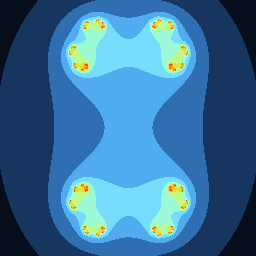

In [ ]:
downloadTexture(outtex, 256, 256)

command stream to file pandecode.dump.0208
pandecode: dump command stream to file pandecode.dump.0209
pandecode: dump command stream to file pandecode.dump.0210
pandecode: dump command stream to file pandecode.dump.0211
pandecode: dump command stream to file pandecode.dump.0212
pandecode: dump command stream to file pandecode.dump.0213
pandecode: dump command stream to file pandecode.dump.0214
pandecode: dump command stream to file pandecode.dump.0215
pandecode: dump command stream to file pandecode.dump.0216
pandecode: dump command stream to file pandecode.dump.0217
pandecode: dump command stream to file pandecode.dump.0218
pandecode: dump command stream to file pandecode.dump.0219
pandecode: dump command stream to file pandecode.dump.0220
pandecode: dump command stream to file pandecode.dump.0221
pandecode: dump command stream to file pandecode.dump.0222
pandecode: dump command stream to file pandecode.dump.0223
pandecode: dump command stream to file pandecode.dump.0224
pandecode: du

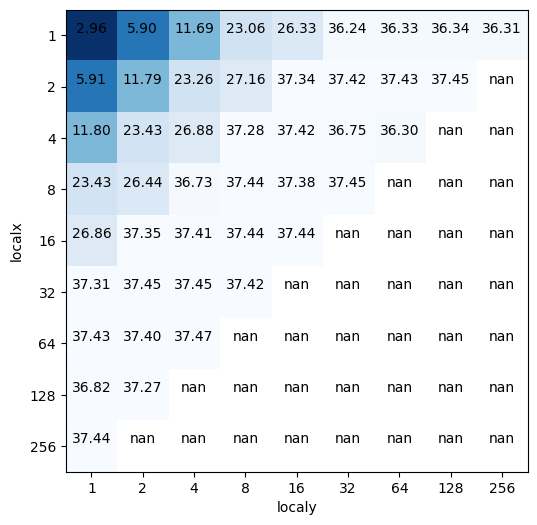

In [ ]:
r = grid_run(test, localx=[1,2,4,8,16,32,64,128,256], localy=[1,2,4,8,16,32,64,128,256])
grid_show(r, colorfun=lambda x: -np.log(x))

## Test 7: Julia fractal (4-way unroll)

In [ ]:
wh = 256
def test(wh=wh, localx=1, localy=1, membw=False):
    global intex, outtex, source
    w,h = wh,wh
    if localx * localy > 256: return float('nan')
    outtex = createTexture(w, h, texid=1, fmt=gl.GL_RGBA32F)
    source = f"""
    #version 310 es
    precision highp float;

    layout(local_size_x = {localx}, local_size_y = {localy}) in;
    layout(rgba32f, binding = 1) uniform mediump writeonly image2D img_output;
    layout(location = 2) uniform int iterations;

    void main() {{
      vec2 p = (vec2(gl_GlobalInvocationID.xy) / vec2({w}.,{h}.) - vec2(0.5)) * vec2(3.);
      int r = 0;

      for(int i = 0; i < iterations / 4; i++) {{
        if(dot(p, p) < 10.) {{
          r++;
        }}
        p = vec2(p.x*p.x - p.y*p.y + 0.7885, 2.*p.x*p.y);
        if(dot(p, p) < 10.) {{
          r++;
        }}
        p = vec2(p.x*p.x - p.y*p.y + 0.7885, 2.*p.x*p.y);
        if(dot(p, p) < 10.) {{
          r++;
        }}
        p = vec2(p.x*p.x - p.y*p.y + 0.7885, 2.*p.x*p.y);
        if(dot(p, p) < 10.) {{
          r++;
        }}
        p = vec2(p.x*p.x - p.y*p.y + 0.7885, 2.*p.x*p.y);
      }} 
      
      float n = float(r) / float(iterations) * 4.;
      
      imageStore(img_output, ivec2(gl_GlobalInvocationID.xy),
              vec4(0.5-cos(n*75.0)/2.0,0.5-cos(n* 120.0)/2.0,0.5-cos(n*165.0)/2.0,1.0));
    }}
    """
    if membw:
        print("\n".join([f"{n+1: 5d}  {line}" for n, line in enumerate(source.split('\n'))]))
    computeShader(source)
    ITERS = 1000
    gl.glUniform1i(2, ITERS)
    start = time.perf_counter()
    for i in range(50):
        gl.glDispatchCompute(w//localx, h//localy, 1)
        # make sure writing to image has finished before read
        gl.glMemoryBarrier(gl.GL_SHADER_IMAGE_ACCESS_BARRIER_BIT)
    gl.glFinish()
    elapsed = (time.perf_counter() - start)/50
    output = downloadTextureFloat(outtex, w, h)
    MACs = 32*ITERS/4*w*h

    if membw:
        print(f"{MACs / elapsed / 1e9:.2f} GFLOPS   {w*h*4*4 / elapsed / 1024 / 1024:.2f} MB/s  {elapsed * 1e3:.2f} ms")
    
    return MACs / elapsed / 1e9

test()
gflops = test(localx=16, localy=16, membw=True)
showLastShaderDisassembly()

    1  
    2      #version 310 es
    3      precision highp float;
    4  
    5      layout(local_size_x = 16, local_size_y = 16) in;
    6      layout(rgba32f, binding = 1) uniform mediump writeonly image2D img_output;
    7      layout(location = 2) uniform int iterations;
    8  
    9      void main() {
   10        vec2 p = (vec2(gl_GlobalInvocationID.xy) / vec2(256.,256.) - vec2(0.5)) * vec2(3.);
   11        int r = 0;
   12  
   13        for(int i = 0; i < iterations / 4; i++) {
   14          if(dot(p, p) < 10.) {
   15            r++;
   16          }
   17          p = vec2(p.x*p.x - p.y*p.y + 0.7885, 2.*p.x*p.y);
   18          if(dot(p, p) < 10.) {
   19            r++;
   20          }
   21          p = vec2(p.x*p.x - p.y*p.y + 0.7885, 2.*p.x*p.y);
   22          if(dot(p, p) < 10.) {
   23            r++;
   24          }
   25          p = vec2(p.x*p.x - p.y*p.y + 0.7885, 2.*p.x*p.y);
   26          if(dot(p, p) < 10.) {
   27            r++;
   28          }
   29

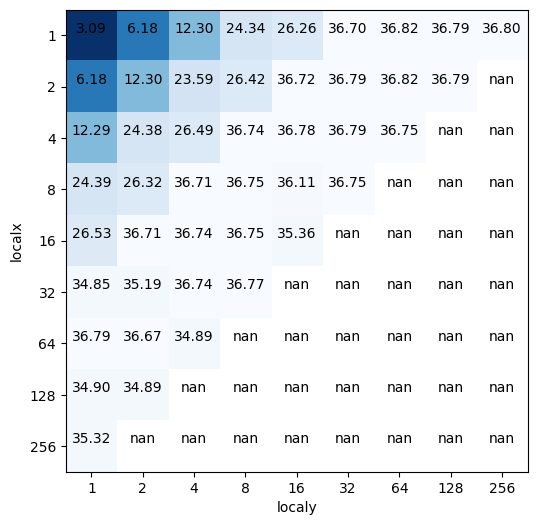

In [ ]:
r = grid_run(test, localx=[1,2,4,8,16,32,64,128,256], localy=[1,2,4,8,16,32,64,128,256])
grid_show(r, colorfun=lambda x: -np.log(x))